In [1]:
import os
import torch
import torchvision

from torchvision.io import read_image

from ShapeDataset import *
from implementations import *

In [2]:
##### Defining some variables #####
num_classes = 3 + 1  # classes + background
classes = ['Background', 'Cube', 'Octahedron', 'Sphere']
hidden_layer = 256
root = './'
data_dir = os.path.join(root,'Data')
annotations = os.path.join(data_dir,'_annotations.coco.json')
model_savename = 'modelsave'

In [3]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

### Defining our model ###
def get_model_instance_segmentation(num_classes, hidden_layer):
    # load an instance segmentation model pre-trained on the COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features # get number of input features for the classifier
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)# replace the pre-trained head with a new one

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # get the number of input features for the mask classifier
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

Let’s now write the main function which performs the training and the
validation:



In [4]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU if available, if not on the CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations to create datasets
dataset      = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(data_dir,annotations, get_transform(train=True)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])
dataset_test = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(data_dir,annotations, get_transform(train=False)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
split_ind = len(dataset)//10
dataset = torch.utils.data.Subset(dataset, indices[:-split_ind])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-split_ind:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes, hidden_layer)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Model finished training.")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch: [0]  [ 0/14]  eta: 0:01:54  lr: 0.000389  loss: 8.3195 (8.3195)  loss_classifier: 1.4946 (1.4946)  loss_box_reg: 0.7561 (0.7561)  loss_mask: 3.4822 (3.4822)  loss_objectness: 2.5047 (2.5047)  loss_rpn_box_reg: 0.0819 (0.0819)  time: 8.2115  data: 0.1212
Epoch: [0]  [10/14]  eta: 0:00:28  lr: 0.004232  loss: 2.6447 (4.2173)  loss_classifier: 0.8140 (0.9652)  loss_box_reg: 0.7561 (0.6958)  loss_mask: 0.7962 (1.3903)  loss_objectness: 0.4360 (1.0596)  loss_rpn_box_reg: 0.0878 (0.1065)  time: 7.1423  data: 0.0975
Epoch: [0]  [13/14]  eta: 0:00:07  lr: 0.005000  loss: 2.6447 (3.8609)  loss_classifier: 0.8239 (0.9727)  loss_box_reg: 0.6488 (0.6370)  loss_mask: 0.7099 (1.2202)  loss_objectness: 0.3785 (0.9024)  loss_rpn_box_reg: 0.0969 (0.1287)  time: 7.3882  data: 0.3029
Epoch: [0] Total time: 0:01:43 (7.3884 s / it)


/Users/johannes/Documents/Uni/Semester7/MachineLearning/ml-project-2-andersmaxjohannes/engine.py:79: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Test:  [0/2]  eta: 0:00:02  model_time: 1.0400 (1.0400)  evaluator_time: 0.2147 (0.2147)  time: 1.3179  data: 0.0632
Test:  [1/2]  eta: 0:00:01  model_time: 1.0376 (1.0388)  evaluator_time: 0.2092 (0.2119)  time: 1.3049  data: 0.0521
Test: Total time: 0:00:02 (1.3052 s / it)
Averaged stats: model_time: 1.0376 (1.0388)  evaluator_time: 0.2092 (0.2119)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

In [ ]:
torch.save(model,'./modelsave') # Saving the model to modelsave

The number of detected instances of each shape in the selected image are:
Cube:100
Octahedron:0
Sphere:0


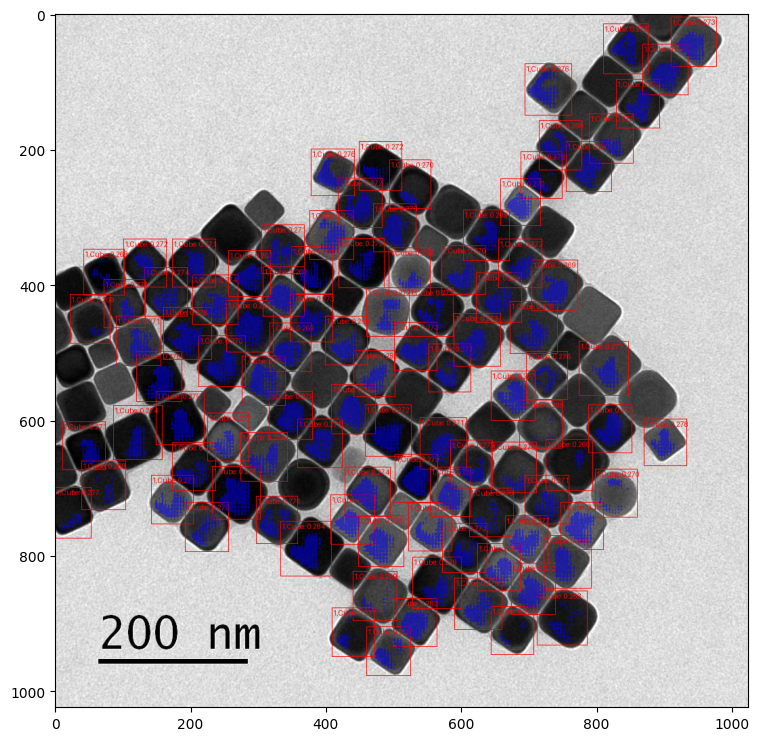

In [12]:
throwaway = predict(model,os.path.join(data_dir,"Cu-s-16_0004_jpg.rf.21708722aff4c9b4c45354b87d9330e9.jpg"),classes,True)